# Retraining Basset with EUGENe
**Authorship:**
Adam Klie (last updated: *07/19/2023*)
***
**Description:**
Test the Kipoi hosted implementation of Basenji for inference on some randomly generated sequences. This is a good place to check if your installation is working properly.
***

# Set-up

In [1]:
# General imports
import os
import time
import h5py
import numpy as np

# Load dataset from EvoAug publication

In [2]:
dataset_path = "/cellar/users/aklie/projects/ML4GLand/data/pubs/lee22/Basset_data.h5"

In [3]:
# Load dataset from h5 file
with h5py.File(dataset_path, 'r') as dataset:
    X_train = np.array(dataset['X_train'])
    y_train = np.array(dataset['Y_train'])
    X_valid = np.array(dataset['X_valid'])
    y_valid = np.array(dataset['Y_valid'])
    X_test = np.array(dataset['X_test'])
    y_test = np.array(dataset['Y_test'])

In [4]:
# Check the shape of the data
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((437478, 4, 600),
 (437478, 164),
 (16410, 4, 600),
 (16410, 164),
 (16703, 4, 600),
 (16703, 164))

In [5]:
# Check training dataset size in mem (GBs)
import sys
X_train.nbytes / 1e9, sys.getsizeof(X_train) / 1e9

(4.1997888, 4.199788944)

# Instantiate model

In [6]:
from eugene.models.zoo import Basset

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
arch = Basset(
    input_len=600, 
    output_dim=164
)
arch

Basset(
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 300, kernel_size=(19,), stride=(1,), padding=(9,))
      (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(300, 200, kernel_size=(11,), stride=(1,), padding=(5,))
      (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
      (8): Conv1d(200, 200, kernel_size=(7,), stride=(1,), padding=(3,))
      (9): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (dense_block): DenseBlock(
    (layers): Sequential(
      (0): Linear(in_features=118400, out_features=1000, bias

In [9]:
from eugene.models import SequenceModule

In [10]:
model = SequenceModule(
    arch=arch,
    task="multilabel_classification",
    loss_fxn="bce",
    optimizer="adam",
    metric_kwargs={
        "task": "multilabel",
        "num_labels": 164
    }
)

In [11]:
from eugene.models import init_weights

In [12]:
init_weights(model)

In [13]:
model.summary()

Model: Basset
Sequence length: 600
Output dimension: 164
Task: multilabel_classification
Loss function: binary_cross_entropy_with_logits
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: None
	Scheduler parameters: {}
Metric: auroc
	Metric parameters: {'task': 'multilabel', 'num_labels': 164}
Seed: None
Parameters summary:


  | Name         | Type            | Params
-------------------------------------------------
0 | arch         | Basset          | 119 M 
1 | train_metric | MultilabelAUROC | 0     
2 | val_metric   | MultilabelAUROC | 0     
3 | test_metric  | MultilabelAUROC | 0     
-------------------------------------------------
119 M     Trainable params
0         Non-trainable params
119 M     Total params
478.238   Total estimated model params size (MB)

# Build dataloader

In [16]:
import seqdata as sd
import xarray as xr

In [27]:
train_sdata = xr.Dataset(
    {
        "ohe_seq": (["_sequence", "_ohe", "_length"], X_train),
        "target": (["_sequence", "_targets"], y_train),
    }
)

valid_sdata = xr.Dataset(
    {
        "ohe_seq": (["_sequence", "_ohe", "_length"], X_valid),
        "target": (["_sequence", "_targets"], y_valid),

    }
)

In [28]:
train_dl = sd.get_torch_dataloader(
    train_sdata,
    batch_size=100,
    sample_dims="_sequence",
    variables=["ohe_seq", "target"],
    shuffle=True,
    num_workers=4,
    prefetch_factor=2,
)

val_dl = sd.get_torch_dataloader(
    valid_sdata,
    batch_size=100,
    sample_dims="_sequence",
    variables=["ohe_seq", "target"],
    shuffle=False,
    num_workers=4,
    prefetch_factor=2,
)

In [29]:
batch = next(iter(train_dl))
batch["ohe_seq"].shape, batch["target"].shape

(torch.Size([100, 4, 600]), torch.Size([100, 164]))

In [30]:
from eugene import train

In [35]:
train.fit(
    model=model,
    train_dataloader=train_dl,
    val_dataloader=val_dl,
    epochs=100,
    gpus=1,
    logger="tensorboard",
    log_dir="/cellar/users/aklie/projects/ML4GLand/models/",  # TODO: change to your own path
    name="Basset",
    version=time.strftime("%Y-%m-%d_%H-%M-%S"),
    early_stopping_patience=10,
    seed=13
)

[rank: 0] Global seed set to 13
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RA

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
import pytorch_lightning as pl

In [75]:
callback_topmodel = pl.callbacks.ModelCheckpoint(monitor='val_loss', 
                                                 save_top_k=1, 
                                                 dirpath="eugene_logs", 
                                                 filename="Basset")
callback_es = pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss', patience=10)

In [76]:
logger = pl.loggers.TensorBoardLogger(save_dir="eugene_logs")
trainer = pl.Trainer(gpus=1, max_epochs=100, auto_select_gpus=True, logger=logger, callbacks=[callback_es, callback_topmodel])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [3]:
# Fit to data
trainer.fit(model, datamodule=data_module)

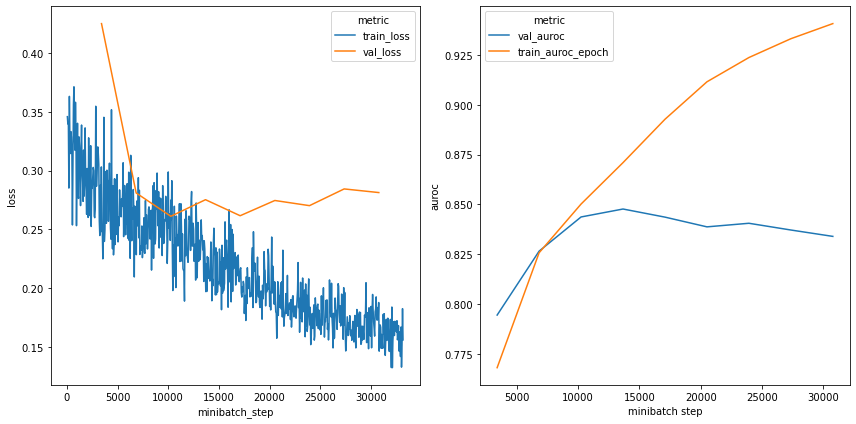

In [7]:
eu.pl.training_summary("eugene_logs/default/version_1/", metric="auroc")

# Evaluate model

In [4]:
MODEL_PATH = "/cellar/users/aklie/projects/EUGENe_use_cases/kelley16/eugene_logs/Basset.ckpt"

In [5]:
best_model = eu.models.Basset.load_from_checkpoint(MODEL_PATH)

None {'num_classes': 164} multilabel_classification
auroc
{'num_classes': 164}
AUROC()
{'regression': {}, 'binary_classification': {'task': 'binary'}, 'multiclass_classification': {'task': 'multiclass'}, 'multilabel_classification': {'task': 'multilabel'}}


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [36]:
data_module.y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
from torchvision import transforms
from eugene.dataload import ToTensor

In [46]:
sdataset = eu.dl.SeqDataset(
    seqs=data_module.x_test, 
    targets=data_module.y_test, 
    names=np.array([f"seq{i}" for i in range(len(data_module.x_test))]),
    transform=transforms.Compose([ToTensor()])
)

In [47]:
sdataset[0]

(tensor([115., 101., 113.,  48.,  36.,  36.,  36.,  36.]),
 tensor([[1., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.]]),
 tensor([-1.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [48]:
sdataloader = sdataset.to_dataloader(batch_size=128, shuffle=False)

In [49]:
trainer = pl.Trainer(gpus=1, auto_select_gpus=True, logger=None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [54]:
pred = np.concatenate(trainer.predict(best_model, dataloaders=sdataloader))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [64]:
preds = pred[:, 1:165].astype(np.float32)
trues = pred[:, 165:].astype(np.float32)
ids = pred[:, 1]

In [65]:
preds

array([[-4.5189333, -4.5125437, -3.7900558, ..., -3.0956502, -3.6418533,
        -4.6703386],
       [-2.5667593, -5.189077 , -2.7265296, ..., -3.2501156, -3.4317393,
        -4.0454507],
       [-6.031025 , -4.0759897, -5.158294 , ..., -3.22485  , -4.0770197,
        -4.8552556],
       ...,
       [-2.4186454, -3.8015072, -2.6640704, ..., -2.250576 , -2.9372458,
        -3.97238  ],
       [-5.2373266, -4.0637956, -4.5207825, ..., -3.826011 , -4.3333616,
        -4.6849017],
       [-2.3885746, -0.86989  , -2.1702073, ..., -2.147847 , -1.6390084,
        -2.1693165]], dtype=float32)

In [66]:
trues

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [67]:
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error
from scipy import stats
def evaluate_model(y_test, pred, task, verbose=True):
    if task == 'regression': #isinstance(pl_model.criterion, torch.nn.modules.loss.MSELoss):
        mse = calculate_mse(y_test, pred)
        pearsonr = calculate_pearsonr(y_test, pred)
        spearmanr = calculate_spearmanr(y_test, pred)
        if verbose:
            print("Test MSE       : %.4f +/- %.4f"%(np.nanmean(mse), np.nanstd(mse)))
            print("Test Pearson r : %.4f +/- %.4f"%(np.nanmean(pearsonr), np.nanstd(pearsonr)))
            print("Test Spearman r: %.4f +/- %.4f"%(np.nanmean(spearmanr), np.nanstd(spearmanr)))
        return mse, pearsonr, spearmanr

    else: 
        auroc = calculate_auroc(y_test, pred) 
        aupr = calculate_aupr(y_test, pred) 
        if verbose:
            print("Test AUROC: %.4f +/- %.4f"%(np.nanmean(auroc), np.nanstd(auroc)))
            print("Test AUPR : %.4f +/- %.4f"%(np.nanmean(aupr), np.nanstd(aupr)))
        return auroc, aupr


def calculate_auroc(y_true, y_score):
    vals = []
    for class_index in range(y_true.shape[-1]):
        vals.append( roc_auc_score(y_true[:,class_index], y_score[:,class_index]) )    
    return np.array(vals)

def calculate_aupr(y_true, y_score):
    vals = []
    for class_index in range(y_true.shape[-1]):
        vals.append( average_precision_score(y_true[:,class_index], y_score[:,class_index]) )    
    return np.array(vals)

In [68]:
results = evaluate_model(trues, preds, "binary", verbose=False)

In [70]:
aurocs = results[0]
auprs = results[1]

In [71]:
aurocs.mean(), auprs.mean()

(0.8451581652547495, 0.5309917392165966)

In [72]:
eu.external.kipoi.get_model_names("Basset")

Already up to date.


2    Basset
Name: model, dtype: object

In [73]:
kipoi_model = eu.external.kipoi.get_model("Basset")

Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/Basset/downloaded/model_files/weights/4878981d84499eb575abd0f3b45570d3


In [77]:
import torch

In [100]:
torch.Tensor(np.expand_dims(data_module.x_test, axis=3))[:1].size()

torch.Size([1, 4, 600, 1])

In [111]:
kipoi_preds = kipoi_model(torch.Tensor(np.expand_dims(data_module.x_test, axis=3))[:1000].to("cuda")).to("cpu").detach().numpy()

In [112]:
results = evaluate_model(trues[:1000], kipoi_preds, "binary", verbose=False)

In [114]:
results[1].mean()

0.6093829996690903

In [116]:
type(kipoi_model)

torch.nn.modules.container.Sequential

In [117]:
kipoi_model.modules

Sequential(
  (0): Conv2d(4, 300, kernel_size=(19, 1), stride=(1, 1))
  (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1))
  (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1))
  (9): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (12): Lambda()
  (13): Sequential(
    (0): Lambda()
    (1): Linear(in_features=2000, out_features=1000, bias=True)
  )
  (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()